In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array, smart_resize
import seaborn as sns
import time
#import cv2


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd '/content/drive/MyDrive/Colab Notebooks/RecycleMates'

/content/drive/MyDrive/Colab Notebooks/RecycleMates


# 1. Importing the dataset

In [5]:
from pathlib import Path
p = Path().cwd()

In [6]:
target_dict = {'can': 0,
               'cardboard': 1,
               'glass bottle': 2,
               'plastic bottle': 3} # create dictionary mapping you data classes/labels to integer labels


# Importing the data
images1 = np.load(p/"images.npy")
labels1 = np.load(p/"labels.npy")
print(images1.shape)
print(labels1.shape)

(5520, 128, 128, 3)
(5520,)


In [7]:
labels_int = [target_dict.get(e, e) for e in labels1] # use the target_dict to convert the string labels to an array of integers
labels_int = np.array(labels_int) # convert the list of int labels to a NumPy array

# 3. Training the models

## 3.1 Splitting the data

In [8]:
from sklearn.model_selection import train_test_split
# 70% for training, 20% for validation, and 10% for testing
X_train, X_test, y_train, y_test = train_test_split(images1, labels_int, test_size=0.1, random_state=42)

In [9]:
## Shuffle the dataset
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

In [10]:
# Normalizing the data and reshaping
X_train = X_train / 255.0
X_test = X_test / 255.0

In [11]:
# Shape of the training dataset
X_train.shape

(4968, 128, 128, 3)

In [12]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, dtype="int")
y_test = to_categorical(y_test, dtype="int")

In [13]:
image_shape = X_train[0].shape
image_shape

(128, 128, 3)

## 3.2 CNN Models

First we are going to train a simple CNN model to use it as a base line for more robust and complex CNN architectures.

### 3.2.1 Baseline model

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, MaxPool2D
from tensorflow.keras import optimizers
from tensorflow.keras import losses

# Creating a baseline model
cnn_model = Sequential()
cnn_model.add(Conv2D(32, 2, 2, padding = 'same', input_shape = image_shape, activation='relu'))
cnn_model.add(MaxPooling2D(pool_size = (3, 3)))
cnn_model.add(Flatten())
cnn_model.add(Dense(32, activation = 'relu'))
cnn_model.add(Dense(4, activation = 'softmax'))

In [21]:
# Compiler settings
cnn_model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 21, 21, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 14112)             0         
                                                                 
 dense (Dense)               (None, 32)                451616    
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
Total params: 452,164
Trainable params: 452,164
Non-trainable params: 0
__________________________________________________

In [23]:
# Trining the CNN model
start_time = time.time()

history_baseline = cnn_model.fit(X_train,
                        y_train,
                        batch_size=128,
                        epochs=10,
                        verbose=1,
                        validation_split=0.2)

elapsed_time = time.time() - start_time

print(elapsed_time)

Epoch 1/10
32/32 [==============================] - 7s 64ms/step - loss: 1.4300 - accuracy: 0.3583 - val_loss: 1.4600 - val_accuracy: 0.2897
Epoch 2/10
32/32 [==============================] - 1s 41ms/step - loss: 1.1338 - accuracy: 0.5176 - val_loss: 1.7147 - val_accuracy: 0.3441
Epoch 3/10
32/32 [==============================] - 1s 26ms/step - loss: 1.0527 - accuracy: 0.5561 - val_loss: 1.3021 - val_accuracy: 0.4467
Epoch 4/10
32/32 [==============================] - 1s 31ms/step - loss: 0.9758 - accuracy: 0.5959 - val_loss: 1.1817 - val_accuracy: 0.4588
Epoch 5/10
32/32 [==============================] - 1s 26ms/step - loss: 0.9171 - accuracy: 0.6314 - val_loss: 1.4259 - val_accuracy: 0.4427
Epoch 6/10
32/32 [==============================] - 1s 26ms/step - loss: 0.8794 - accuracy: 0.6573 - val_loss: 1.7457 - val_accuracy: 0.4276
Epoch 7/10
32/32 [==============================] - 1s 26ms/step - loss: 0.8522 - accuracy: 0.6772 - val_loss: 0.9881 - val_accuracy: 0.5433
Epoch 8/10
32

Here we are creating a function to plot a fig with two chart showing the loss and accuracy metrics during the trining and validation process.

In [14]:
def loss_accuracy_fig(model_history):
  history_dict = model_history.history
  # loss values
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']
  epochs = range(1, len(loss_values) + 1)
  # Accuracy values
  acc_values = history_dict['accuracy']
  val_acc_values = history_dict['val_accuracy']

  # Create a new figure and two subplots
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

  # Plot the training loss on the first subplot (ax1)
  ax1.plot(epochs, loss_values, 'b', label="Training Loss")
  ax1.plot(epochs, val_loss_values, 'r', label="Validation Loss")
  ax1.set_title("Training and Validation Loss")
  ax1.set_xlabel("Epochs")
  ax1.set_xticks(epochs)
  ax1.set_ylabel("Loss")
  ax1.legend()


  # Plot the validation loss on the second subplot (ax2)
  ax2.plot(epochs, acc_values, 'b', label="Training Accuracy")
  ax2.plot(epochs, val_acc_values, 'r', label="Validation Accuracy")
  ax2.set_title("Training and Validation Accuracy")
  ax2.set_xlabel("Epochs")
  ax2.set_xticks(epochs)
  ax2.set_ylabel("Accuracy")
  ax2.legend()

  # Adjust layout to prevent overlapping of subplots
  plt.tight_layout()

  plt.show()

In [ ]:
loss_accuracy_fig(history_baseline)

This basline model got an accuracy about 65% so any model more complex that this baseline should get a better performance clasifying the objects.

## Testing Pretrained CNN models

In [15]:
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.applications import VGG16, ResNet50, ResNet152V2, MobileNetV2, DenseNet201, NASNetLarge, EfficientNetV2M
from keras.optimizers import RMSprop


### Importing the models

Here we are going to import several famous trained CNN architectures like VGG16, ResNet50, ResNet152V2, MobileNetV2, DenseNet201, NASNetLarge and EfficientNetV2M.  

We are going to import these models without the top layers so we can modify the output specifically for our targets objects, in this case we want to clasify 4 different class of objects. In addition we are initiating the input of those models with  the shape of our images.  

Then we are going to compare those models using different performance metrics and characteristics to compare which one fit best for our porpose.

In [19]:
# Load VGG16 model with pretrained weights (excluding the top Dense layers)
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=image_shape)

# Load ResNet50 model with pretrained weights (excluding the top Dense layers)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=image_shape)
# Note: each Keras Application expects a specific kind of input preprocessing.
# For ResNet, call tf.keras.applications.resnet.preprocess_input on your inputs before passing them to the model.
# resnet.preprocess_input will convert the input images from RGB to BGR, then will zero-center each color channel with respect to the ImageNet dataset, without scaling.

# Load ResNet152V2 model with pretrained weights (excluding the top Dense layers)
resnet152v2_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=image_shape)
# Note: each Keras Application expects a specific kind of input preprocessing.
# For ResNetV2, call tf.keras.applications.resnet_v2.preprocess_input on your inputs before passing them to the model.
# resnet_v2.preprocess_input will scale input pixels between -1 and 1.

# Load MobileNetV2 model with pretrained weights (excluding the top Dense layers)
mobilenetv2_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=image_shape)

# Load DenseNet201 model with pretrained weights (excluding the top Dense layers)
densenet201_model = DenseNet201(weights='imagenet', include_top=False, input_shape=image_shape)

# Load NASNetLarge model with pretrained weights (excluding the top Dense layers)
nasnetlarge_model = NASNetLarge(weights='imagenet', include_top=False, input_shape=image_shape)

# Load EfficientNetV2M model with pretrained weights (excluding the top Dense layers)
efficientnetv2m_model = EfficientNetV2M(weights='imagenet', include_top=False, input_shape=image_shape, include_preprocessing = False)
# Note: each Keras Application expects a specific kind of input preprocessing. For EfficientNetV2, by default input preprocessing is included
# as a part of the model (as a Rescaling layer), and thus tf.keras.applications.efficientnet_v2.preprocess_input is actually a pass-through function.
# In this use case, EfficientNetV2 models expect their inputs to be float tensors of pixels with values in the [0-255] range.


In [20]:
# densenet201_model.summary()

As all these model were trained with thousands of images of different classes we do not want to mess all the work done training these neurons so we are going to set all the trainable layers as FALSE in orden to keep the upgraded weights belonging to these architectures.

In [21]:
# We do not want to overwrite the wight of these trained models
for layer in vgg16_model.layers:
    layer.trainable = False

for layer in resnet50_model.layers:
    layer.trainable = False

for layer in resnet152v2_model.layers:
    layer.trainable = False

for layer in mobilenetv2_model.layers:
    layer.trainable = False

for layer in densenet201_model.layers:
    layer.trainable = False

for layer in nasnetlarge_model.layers:
    layer.trainable = False

for layer in efficientnetv2m_model.layers:
    layer.trainable = False


### VGG16

The first model that we are going to try is the VGG16 architecture and for all the models the code sequence will be the same.  

First we create the top and output neural structure which containg a sequential network integrated by fully conected neural networks, afterwrd we have to combine this output layers with the model that was instanciated when we imported the neural network.

Then we set the compiler with the different metrics used to updrade the gradient decent algorithm.  

Finally, we start the training phace using out training dataset as well as setting different parameters like batch size, number of epochs and the validation dataset size.


In [22]:
# Create a Sequential model for VGG16
vgg16_top_model = Sequential()
vgg16_top_model.add(Flatten(input_shape=(vgg16_model.output_shape[1:])))
vgg16_top_model.add(Dense(32, activation='relu'))
vgg16_top_model.add(Dense(4, activation='softmax'))

# Concatenate the VGG16 top models
vgg16_merge_model = Sequential()
vgg16_merge_model.add(vgg16_model)
vgg16_merge_model.add(vgg16_top_model)

In [23]:
vgg16_merge_model.compile(optimizer=RMSprop(),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [24]:
start_time = time.time()

vgg16_history = vgg16_merge_model.fit(X_train,
                           y_train,
                           batch_size=64,
                           epochs=20,
                           verbose=1,
                           validation_split=0.2)

elapsed_time = time.time() - start_time
vgg16_time = elapsed_time
print(elapsed_time)

Epoch 1/20
63/63 [==============================] - 21s 163ms/step - loss: 0.8253 - accuracy: 0.6678 - val_loss: 0.6580 - val_accuracy: 0.7384
Epoch 2/20
63/63 [==============================] - 6s 101ms/step - loss: 0.4298 - accuracy: 0.8432 - val_loss: 0.7646 - val_accuracy: 0.7012
Epoch 3/20
63/63 [==============================] - 8s 124ms/step - loss: 0.3222 - accuracy: 0.8888 - val_loss: 0.3484 - val_accuracy: 0.8793
Epoch 4/20
63/63 [==============================] - 8s 123ms/step - loss: 0.2427 - accuracy: 0.9182 - val_loss: 0.4412 - val_accuracy: 0.8139
Epoch 5/20
63/63 [==============================] - 8s 126ms/step - loss: 0.1923 - accuracy: 0.9368 - val_loss: 0.3537 - val_accuracy: 0.8773
Epoch 6/20
63/63 [==============================] - 8s 125ms/step - loss: 0.1499 - accuracy: 0.9519 - val_loss: 0.3430 - val_accuracy: 0.8742
Epoch 7/20
63/63 [==============================] - 7s 105ms/step - loss: 0.1267 - accuracy: 0.9615 - val_loss: 0.4238 - val_accuracy: 0.8400
Epoch

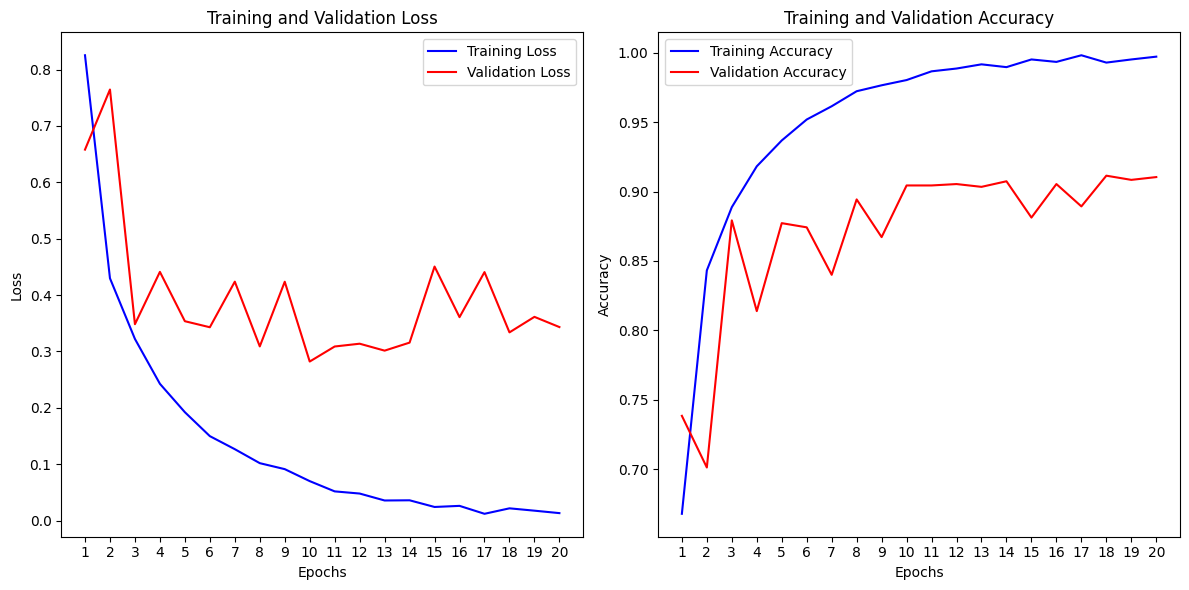

In [25]:
# VGG16 Loss and accuracy fig
loss_accuracy_fig(vgg16_history)

In [26]:
# Saving the model
vgg16_merge_model.save(p/"vgg16_merge_model.h5")

### ResNet50

In [ ]:
# Create a Sequential model for ResNet50
resnet50_top_model = Sequential()

resnet50_top_model.add(Flatten(input_shape=resnet50_model.output_shape[1:]))
resnet50_top_model.add(Dense(32, activation='relu'))
resnet50_top_model.add(Dense(4, activation='softmax'))

# Concatenate the ResNet50 top models
resnet50_merge_model = Sequential()
resnet50_merge_model.add(resnet50_model)
resnet50_merge_model.add(resnet50_top_model)

In [ ]:
resnet50_merge_model.compile(optimizer=RMSprop(),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [ ]:
start_time = time.time()

resnet50_history = resnet50_merge_model.fit(tf.keras.applications.resnet.preprocess_input(X_train*255),
                           y_train,
                           batch_size=128,
                           epochs=20,
                           verbose=1,
                           validation_split=0.2)

elapsed_time = time.time() - start_time
print(elapsed_time)
resnet50_time = elapsed_time

Epoch 1/20
32/32 [==============================] - 11s 214ms/step - loss: 5.2644 - accuracy: 0.7285 - val_loss: 1.0805 - val_accuracy: 0.8722
Epoch 2/20
32/32 [==============================] - 5s 161ms/step - loss: 1.0093 - accuracy: 0.8820 - val_loss: 0.6509 - val_accuracy: 0.9004
Epoch 3/20
32/32 [==============================] - 5s 162ms/step - loss: 0.3643 - accuracy: 0.9487 - val_loss: 1.3824 - val_accuracy: 0.8773
Epoch 4/20
32/32 [==============================] - 5s 170ms/step - loss: 0.1878 - accuracy: 0.9680 - val_loss: 1.6766 - val_accuracy: 0.7907
Epoch 5/20
32/32 [==============================] - 5s 166ms/step - loss: 0.0972 - accuracy: 0.9814 - val_loss: 7.1098 - val_accuracy: 0.5905
Epoch 6/20
32/32 [==============================] - 5s 161ms/step - loss: 0.3042 - accuracy: 0.9726 - val_loss: 0.9978 - val_accuracy: 0.8974
Epoch 7/20
32/32 [==============================] - 5s 170ms/step - loss: 0.4119 - accuracy: 0.9612 - val_loss: 0.5899 - val_accuracy: 0.9447
Epoch

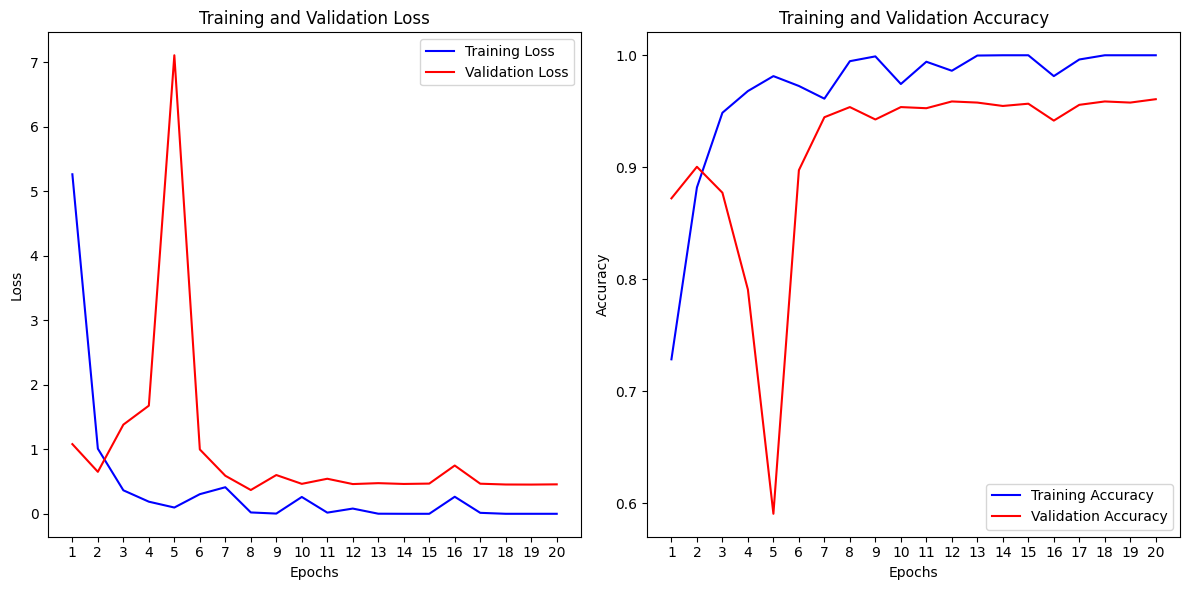

In [ ]:
# ResNet50 Loss and accuracy fig
loss_accuracy_fig(resnet50_history)

In [ ]:
# Saving the model
resnet50_merge_model.save(p/"resnet50_merge_model.h5")

### ResNet152V2

In [ ]:
# Create a Sequential model for ResNet152V2
resnet152v2_top_model = Sequential()
resnet152v2_top_model.add(Flatten(input_shape=resnet152v2_model.output_shape[1:]))
resnet152v2_top_model.add(Dense(32, activation='relu'))
resnet152v2_top_model.add(Dense(4, activation='softmax'))

# Concatenate the ResNet152V2 top models
resnet152v2_merge_model = Sequential()
resnet152v2_merge_model.add(resnet152v2_model)
resnet152v2_merge_model.add(resnet152v2_top_model)

In [ ]:
resnet152v2_merge_model.compile(optimizer=RMSprop(),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [ ]:
start_time = time.time()

resnet152v2_history = resnet152v2_merge_model.fit(tf.keras.applications.resnet_v2.preprocess_input(X_train*255),
                           y_train,
                           batch_size=128,
                           epochs=20,
                           verbose=1,
                           validation_split=0.2)

elapsed_time = time.time() - start_time
print(elapsed_time)
resnet152v2_time = elapsed_time

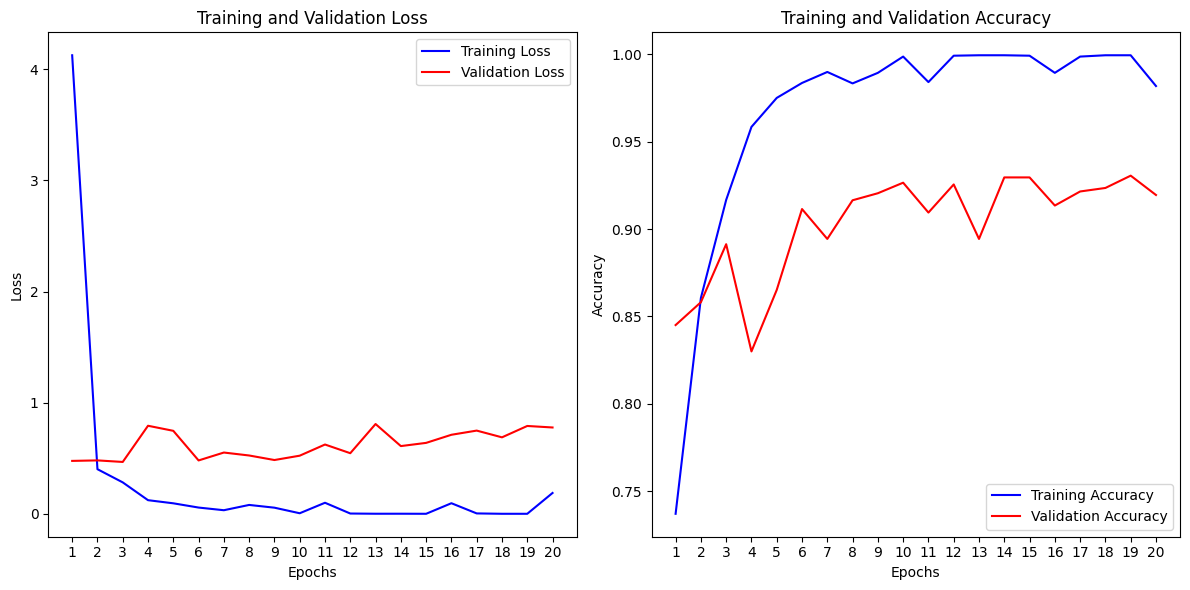

In [ ]:
# ResNet50 Loss and accuracy fig
loss_accuracy_fig(resnet152v2_history)

In [ ]:
# Saving the model
resnet152v2_merge_model.save(p/"resnet152v2_merge_model.h5")

### MobilNetV2

In [ ]:
# Create a Sequential model for MobilNetV2
mobilenetv2_top_model = Sequential()
mobilenetv2_top_model.add(Flatten(input_shape=(mobilenetv2_model.output_shape[1:])))
mobilenetv2_top_model.add(Dense(32, activation='relu'))
mobilenetv2_top_model.add(Dense(4, activation='softmax'))

# Concatenate the MobilNetV2 top models
mobilenetv2_merge_model = Sequential()
mobilenetv2_merge_model.add(mobilenetv2_model)
mobilenetv2_merge_model.add(mobilenetv2_top_model)

In [ ]:
mobilenetv2_merge_model.compile(optimizer=RMSprop(),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [ ]:
start_time = time.time()

mobilenetv2_history = mobilenetv2_merge_model.fit(X_train,
                           y_train,
                           batch_size=128,
                           epochs=20,
                           verbose=1,
                           validation_split=0.2)

elapsed_time = time.time() - start_time
print(elapsed_time)
mobilenetv2_time = elapsed_time

Epoch 1/20
32/32 [==============================] - 8s 163ms/step - loss: 1.8348 - accuracy: 0.7333 - val_loss: 0.5799 - val_accuracy: 0.7958
Epoch 2/20
32/32 [==============================] - 2s 78ms/step - loss: 0.4992 - accuracy: 0.8827 - val_loss: 0.2445 - val_accuracy: 0.9266
Epoch 3/20
32/32 [==============================] - 2s 78ms/step - loss: 0.1669 - accuracy: 0.9517 - val_loss: 0.2661 - val_accuracy: 0.9276
Epoch 4/20
32/32 [==============================] - 2s 71ms/step - loss: 0.1033 - accuracy: 0.9728 - val_loss: 0.5287 - val_accuracy: 0.8702
Epoch 5/20
32/32 [==============================] - 2s 71ms/step - loss: 0.1314 - accuracy: 0.9690 - val_loss: 0.1899 - val_accuracy: 0.9447
Epoch 6/20
32/32 [==============================] - 2s 78ms/step - loss: 0.0410 - accuracy: 0.9882 - val_loss: 0.5164 - val_accuracy: 0.8732
Epoch 7/20
32/32 [==============================] - 3s 81ms/step - loss: 0.0177 - accuracy: 0.9960 - val_loss: 0.2349 - val_accuracy: 0.9416
Epoch 8/20
3

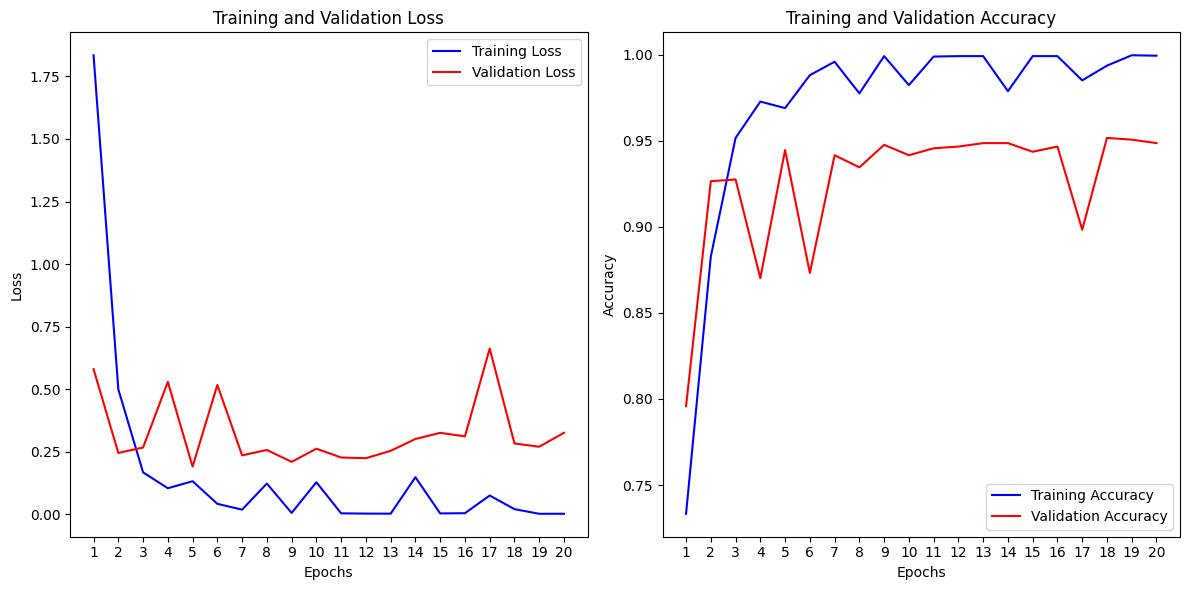

In [ ]:
# MobileNetV2 Loss and accuracy fig
loss_accuracy_fig(mobilenetv2_history)

In [ ]:
# Saving the model
mobilenetv2_merge_model.save(p/"mobilenetv2_merge_model.h5")

### DenseNet201

In [ ]:
# Create a Sequential model for DenseNet201
densenet201_top_model = Sequential()
densenet201_top_model.add(Flatten(input_shape=(densenet201_model.output_shape[1:])))
densenet201_top_model.add(Dense(32, activation='relu'))
densenet201_top_model.add(Dense(4, activation='softmax'))

# Concatenate the DenseNet201 top models
densenet201_merge_model = Sequential()
densenet201_merge_model.add(densenet201_model)
densenet201_merge_model.add(densenet201_top_model)

In [ ]:
densenet201_merge_model.compile(optimizer=RMSprop(),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [ ]:
start_time = time.time()

densenet201_history = densenet201_merge_model.fit(X_train,
                           y_train,
                           batch_size=128,
                           epochs=20,
                           verbose=1,
                           validation_split=0.2)

elapsed_time = time.time() - start_time
print(elapsed_time)
densenet201_time = elapsed_time

Epoch 1/20
32/32 [==============================] - 33s 568ms/step - loss: 6.0418 - accuracy: 0.5639 - val_loss: 4.3923 - val_accuracy: 0.3763
Epoch 2/20
32/32 [==============================] - 7s 225ms/step - loss: 0.9043 - accuracy: 0.7881 - val_loss: 0.6370 - val_accuracy: 0.7958
Epoch 3/20
32/32 [==============================] - 7s 228ms/step - loss: 0.8827 - accuracy: 0.7962 - val_loss: 0.3271 - val_accuracy: 0.9024
Epoch 4/20
32/32 [==============================] - 8s 263ms/step - loss: 0.5252 - accuracy: 0.8913 - val_loss: 0.3703 - val_accuracy: 0.9004
Epoch 5/20
32/32 [==============================] - 7s 225ms/step - loss: 0.1470 - accuracy: 0.9484 - val_loss: 1.3995 - val_accuracy: 0.7254
Epoch 6/20
32/32 [==============================] - 9s 272ms/step - loss: 0.5898 - accuracy: 0.9175 - val_loss: 1.6504 - val_accuracy: 0.7133
Epoch 7/20
32/32 [==============================] - 7s 226ms/step - loss: 0.1996 - accuracy: 0.9477 - val_loss: 0.5717 - val_accuracy: 0.8783
Epoch

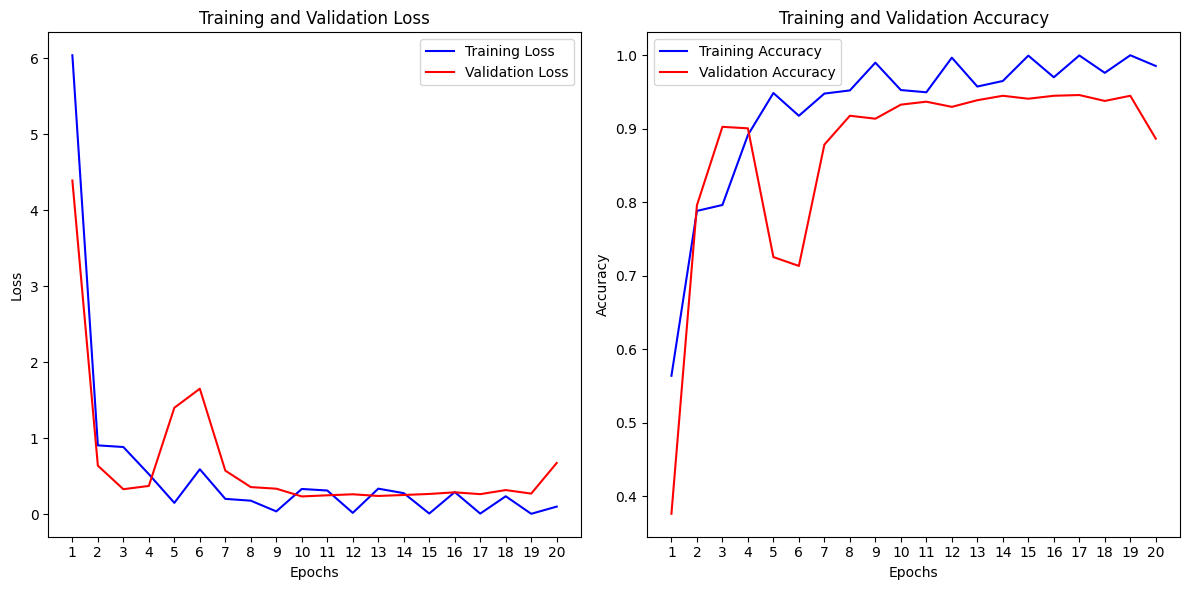

In [ ]:
# MobileNetV2 Loss and accuracy fig
loss_accuracy_fig(densenet201_history)

In [ ]:
# Saving the model
densenet201_merge_model.save(p/"densenet201_merge_model.h5")

### NASNetLarge

In [ ]:
# Create a Sequential model for NASNetLarge
nasnetlarge_top_model = Sequential()
nasnetlarge_top_model.add(Flatten(input_shape=(nasnetlarge_model.output_shape[1:])))
nasnetlarge_top_model.add(Dense(32, activation='relu'))
nasnetlarge_top_model.add(Dense(4, activation='softmax'))

# Concatenate the NASNetLarge top models
nasnetlarge_merge_model = Sequential()
nasnetlarge_merge_model.add(nasnetlarge_model)
nasnetlarge_merge_model.add(nasnetlarge_top_model)

In [ ]:
nasnetlarge_merge_model.compile(optimizer=RMSprop(),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [ ]:
start_time = time.time()

nasnetlarge_history = nasnetlarge_merge_model.fit(X_train,
                           y_train,
                           batch_size=128,
                           epochs=20,
                           verbose=1,
                           validation_split=0.2)

elapsed_time = time.time() - start_time
print(elapsed_time)
nasnetlarge_time = elapsed_time

Epoch 1/20
32/32 [==============================] - 55s 1s/step - loss: 0.9772 - accuracy: 0.7949 - val_loss: 0.4933 - val_accuracy: 0.8561
Epoch 2/20
32/32 [==============================] - 20s 636ms/step - loss: 0.2330 - accuracy: 0.9283 - val_loss: 0.3647 - val_accuracy: 0.8783
Epoch 3/20
32/32 [==============================] - 19s 588ms/step - loss: 0.1309 - accuracy: 0.9612 - val_loss: 0.3835 - val_accuracy: 0.8903
Epoch 4/20
32/32 [==============================] - 20s 638ms/step - loss: 0.0494 - accuracy: 0.9849 - val_loss: 0.5081 - val_accuracy: 0.8944
Epoch 5/20
32/32 [==============================] - 20s 644ms/step - loss: 0.0228 - accuracy: 0.9925 - val_loss: 0.4437 - val_accuracy: 0.9095
Epoch 6/20
32/32 [==============================] - 21s 646ms/step - loss: 0.0430 - accuracy: 0.9894 - val_loss: 0.4753 - val_accuracy: 0.9095
Epoch 7/20
32/32 [==============================] - 20s 621ms/step - loss: 0.0221 - accuracy: 0.9947 - val_loss: 0.6096 - val_accuracy: 0.9034
Ep

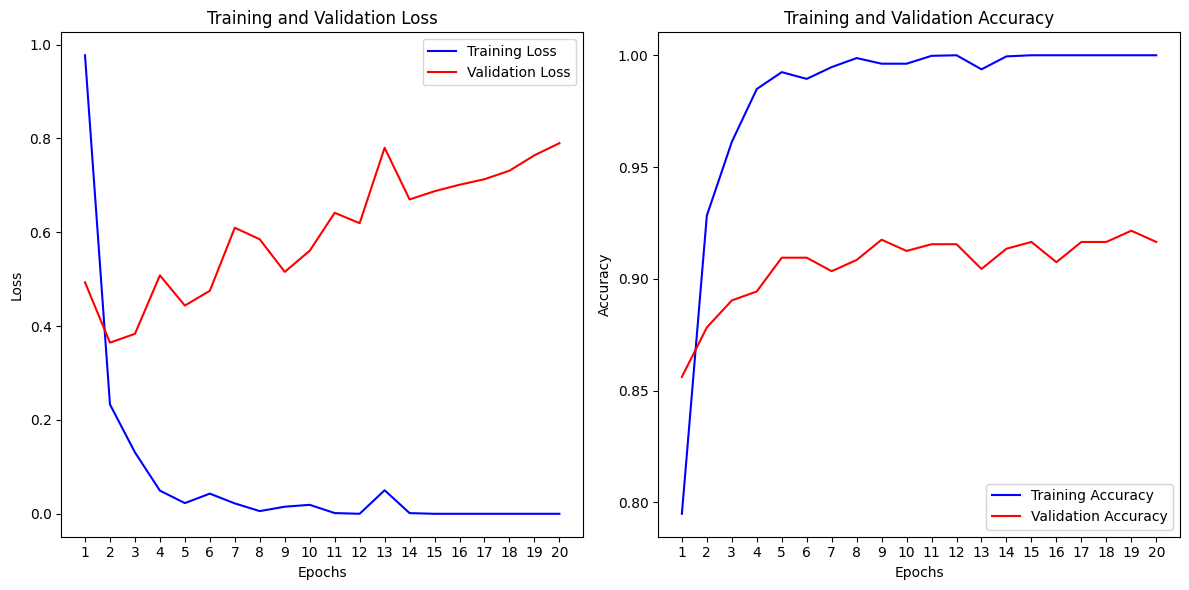

In [ ]:
# MobileNetV2 Loss and accuracy fig
loss_accuracy_fig(nasnetlarge_history)

In [ ]:
# Saving the model
nasnetlarge_merge_model.save(p/"nasnetlarge_merge_model.h5")

### EfficientNetV2M

In [ ]:
# Create a Sequential model for NASNetLarge
efficientnetv2m_top_model = Sequential()
efficientnetv2m_top_model.add(Flatten(input_shape=(efficientnetv2m_model.output_shape[1:])))
efficientnetv2m_top_model.add(Dense(32, activation='relu'))
efficientnetv2m_top_model.add(Dense(4, activation='softmax'))

# Concatenate the NASNetLarge top models
efficientnetv2m_merge_model = Sequential()
efficientnetv2m_merge_model.add(efficientnetv2m_model)
efficientnetv2m_merge_model.add(efficientnetv2m_top_model)

In [ ]:
efficientnetv2m_merge_model.compile(optimizer=RMSprop(),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [ ]:
start_time = time.time()

efficientnetv2m_history = efficientnetv2m_merge_model.fit(X_train,
                           y_train,
                           batch_size=128,
                           epochs=20,
                           verbose=1,
                           validation_split=0.2)

elapsed_time = time.time() - start_time
print(elapsed_time)
efficientnetv2m_time = elapsed_time

Epoch 1/20
32/32 [==============================] - 39s 521ms/step - loss: 1.0375 - accuracy: 0.7282 - val_loss: 1.4784 - val_accuracy: 0.5755
Epoch 2/20
32/32 [==============================] - 11s 354ms/step - loss: 0.3913 - accuracy: 0.8626 - val_loss: 1.0776 - val_accuracy: 0.6932
Epoch 3/20
32/32 [==============================] - 11s 356ms/step - loss: 0.3215 - accuracy: 0.8842 - val_loss: 0.2515 - val_accuracy: 0.9004
Epoch 4/20
32/32 [==============================] - 11s 352ms/step - loss: 0.2242 - accuracy: 0.9160 - val_loss: 0.5660 - val_accuracy: 0.8239
Epoch 5/20
32/32 [==============================] - 11s 353ms/step - loss: 0.1718 - accuracy: 0.9378 - val_loss: 1.0531 - val_accuracy: 0.7183
Epoch 6/20
32/32 [==============================] - 11s 351ms/step - loss: 0.1466 - accuracy: 0.9479 - val_loss: 0.2448 - val_accuracy: 0.9145
Epoch 7/20
32/32 [==============================] - 12s 363ms/step - loss: 0.1633 - accuracy: 0.9449 - val_loss: 0.2112 - val_accuracy: 0.9286

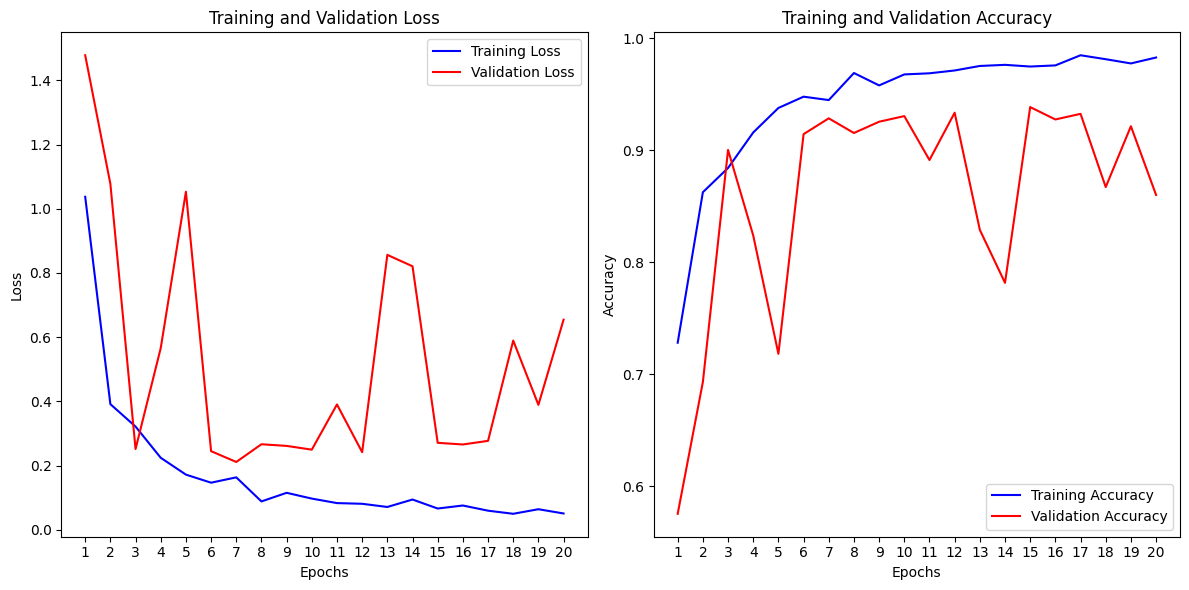

In [ ]:
# MobileNetV2 Loss and accuracy fig
loss_accuracy_fig(efficientnetv2m_history)

In [ ]:
# Saving the model
efficientnetv2m_merge_model.save(p/"efficientnetv2m_merge_model.h5")

## Comparing Pretrained CNN models

First we are going to load all the pretrained models that we used in our object clasification model and in this way we do not have to make again all the training part using our dataset.

In [54]:
# Recreate the exact same model, including its weights and the optimizer
vgg16_merge_model = tf.keras.models.load_model('vgg16_merge_model.h5')
resnet50_merge_model = tf.keras.models.load_model('resnet50_merge_model.h5')
resnet152v2_merge_model = tf.keras.models.load_model('resnet152v2_merge_model.h5')
mobilenetv2_merge_model = tf.keras.models.load_model('mobilenetv2_merge_model.h5')
densenet201_merge_model = tf.keras.models.load_model('densenet201_merge_model.h5')
nasnetlarge_merge_model = tf.keras.models.load_model('nasnetlarge_merge_model.h5')
efficientnetv2m_merge_model = tf.keras.models.load_model('efficientnetv2m_merge_model.h5')

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.utils.multiclass import unique_labels


In [108]:
def evaluate_models(models, model_names, X_test, y_test, class_names):
    evaluation_data = []
    evaluation_data_perclass = []
    fig, axs = plt.subplots(1, len(models), figsize=(40, 4))
    for i, model in enumerate(models):

        # General metrics
        if  model == "resnet50_merge_model":
          # Get model predictions
          y_pred = model.predict(tf.keras.applications.resnet.preprocess_input(X_test*255))
        elif model == "resnet152v2_merge_model":
          y_pred = model.predict(tf.keras.applications.resnet_v2.preprocess_input(X_test*255))
        else:
          y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Create confusion matrix
        cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)
        classes = [class_names[idx] for idx in unique_labels(np.argmax(y_test, axis=1), y_pred_classes)]

        # Calculate evaluation metrics
        accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred_classes)*100
        precision = precision_score(np.argmax(y_test, axis=1), y_pred_classes, average='weighted')*100
        recall = recall_score(np.argmax(y_test, axis=1), y_pred_classes, average='weighted')*100
        f1 = f1_score(np.argmax(y_test, axis=1), y_pred_classes, average='weighted')*100


        # Append model evaluation metrics to the list
        evaluation_data.append([model_names[i], accuracy, precision, recall, f1])

        # Plot the confusion matrix as a heatmap
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes, ax=axs[i], cbar = False)
        axs[i].set_title(model_names[i])
        axs[i].set_xlabel('Predicted Label')
        axs[i].set_ylabel('True Label')

        # Rotate the x-axis tick labels 90 degrees counterclockwise
        axs[i].set_xticklabels(classes, rotation=0)


        # Per-class metrics - Get model predictions
        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_test, axis=1)

        # Calculate per-class metrics
        metrics_per_class = {}
        for idx, class_name in enumerate(classes):
            tp = cm[idx, idx]
            tn = np.sum(np.delete(np.delete(cm, idx, axis=0), idx, axis=1))
            fp = np.sum(cm[:, idx]) - tp
            fn = np.sum(cm[idx, :]) - tp

            accuracy = (tp + tn) / np.sum(cm[idx, :])
            precision = tp / (tp + fp) if tp + fp > 0 else 0
            recall = tp / (tp + fn) if tp + fn > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

            metrics_per_class[class_name] = {
                "Accuracy": accuracy,
                "Precision": precision,
                "Recall": recall,
                "F1 Score": f1
            }
        # Append model evaluation metrics to the list
        evaluation_data_perclass.append([model_names[i], metrics_per_class])

    # Create a DataFrame to display the evaluation metrics
    columns = ["Model", "Accuracy", "Precision", "Recall", "F1 Score"]
    df = pd.DataFrame(evaluation_data, columns=columns)
    columns = ["Model", "Metrics"]
    df1 = pd.DataFrame(evaluation_data_perclass, columns=columns)

    # Convert values to percentages without decimal points
    df["Accuracy"] = df["Accuracy"].apply(lambda x: f"{x:.0f}%")
    df["Precision"] = df["Precision"].apply(lambda x: f"{x:.0f}%")
    df["Recall"] = df["Recall"].apply(lambda x: f"{x:.0f}%")
    df["F1 Score"] = df["F1 Score"].apply(lambda x: f"{x:.0f}%")

    plt.tight_layout()
    CM = plt.show()
    return CM, df, df1

18/18 [==============================] - 1s 31ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


18/18 [==============================] - 1s 72ms/step


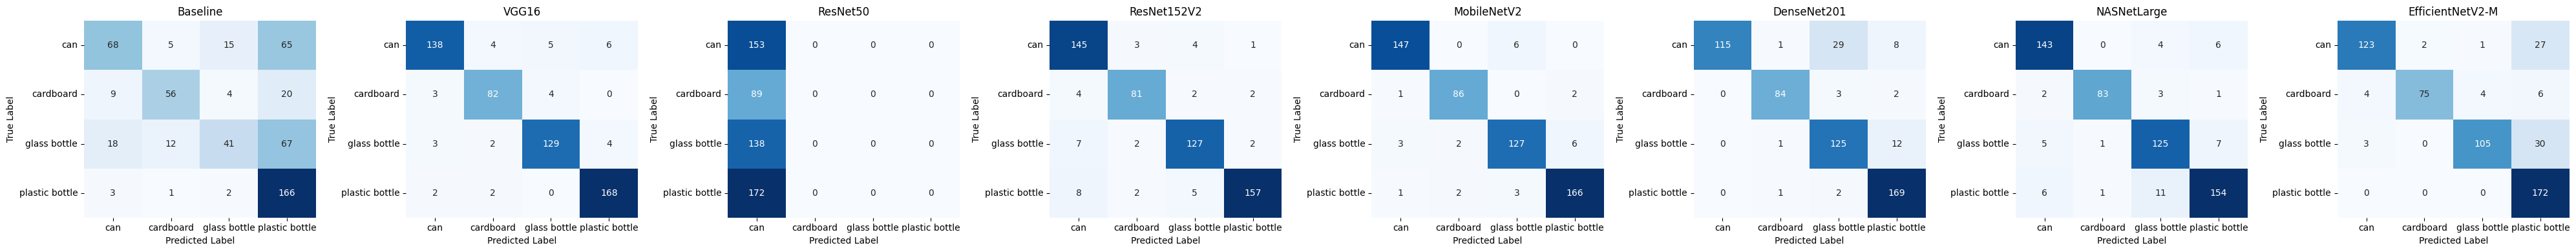

In [109]:
#The models and model names
models = [cnn_model, vgg16_merge_model, resnet50_merge_model, resnet152v2_merge_model, mobilenetv2_merge_model, densenet201_merge_model, nasnetlarge_merge_model, efficientnetv2m_merge_model]
model_names = ["Baseline", "VGG16", "ResNet50", "ResNet152V2", "MobileNetV2", "DenseNet201", "NASNetLarge", "EfficientNetV2-M"]

# class_names is a list of class labels (e.g., ["Class A", "Class B", "Class C", "Class D"])
class_names = ["can", "cardboard", "glass bottle", "plastic bottle"]

plot, df, df1 = evaluate_models(models, model_names, X_test, y_test, class_names)

In [110]:
from google.colab import data_table

data_table.enable_dataframe_formatter()

df

,Model,Accuracy,Precision,Recall,F1 Score
0,Baseline,60%,64%,60%,57%
1,VGG16,94%,94%,94%,94%
2,ResNet50,28%,8%,28%,12%
3,ResNet152V2,92%,93%,92%,92%
4,MobileNetV2,95%,95%,95%,95%
5,DenseNet201,89%,91%,89%,89%
6,NASNetLarge,91%,92%,91%,92%
7,EfficientNetV2-M,86%,89%,86%,86%


In [111]:
df1

,Model,Metrics
0,Baseline,"{'can': {'Accuracy': 2.8562091503267975, 'Prec..."
1,VGG16,"{'can': {'Accuracy': 3.457516339869281, 'Preci..."
2,ResNet50,"{'can': {'Accuracy': 1.0, 'Precision': 0.27717..."
3,ResNet152V2,"{'can': {'Accuracy': 3.4313725490196076, 'Prec..."
4,MobileNetV2,"{'can': {'Accuracy': 3.5359477124183005, 'Prec..."
5,DenseNet201,"{'can': {'Accuracy': 3.3594771241830066, 'Prec..."
6,NASNetLarge,"{'can': {'Accuracy': 3.457516339869281, 'Preci..."
7,EfficientNetV2-M,"{'can': {'Accuracy': 3.366013071895425, 'Preci..."


### 4 Training CNN Model from Scratch

In [ ]:
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=image_shape))
model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(4, activation='softmax'))

In [ ]:
# Explore the structure of the NN
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 conv2d_2 (Conv2D)           (None, 126, 126, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        36928     
                                                      

In [ ]:
model2.compile(loss ='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics =['accuracy'])

In [ ]:
start_time = time.time()

history1 = model2.fit(X_train, y_train,
                      batch_size=128,
                      epochs=10,
                      verbose=1,
                      validation_split=0.2)

elapsed_time = time.time() - start_time

print(elapsed_time)

Epoch 1/10
32/32 [==============================] - 17s 293ms/step - loss: 1.4155 - accuracy: 0.2813 - val_loss: 1.3452 - val_accuracy: 0.3199
Epoch 2/10
32/32 [==============================] - 6s 194ms/step - loss: 1.3221 - accuracy: 0.3397 - val_loss: 1.2868 - val_accuracy: 0.3541
Epoch 3/10
32/32 [==============================] - 6s 183ms/step - loss: 1.1958 - accuracy: 0.4650 - val_loss: 1.1718 - val_accuracy: 0.4899
Epoch 4/10
32/32 [==============================] - 6s 195ms/step - loss: 1.0760 - accuracy: 0.5274 - val_loss: 1.0187 - val_accuracy: 0.5543
Epoch 5/10
32/32 [==============================] - 6s 196ms/step - loss: 0.9758 - accuracy: 0.5881 - val_loss: 1.0038 - val_accuracy: 0.5825
Epoch 6/10
32/32 [==============================] - 6s 196ms/step - loss: 0.8980 - accuracy: 0.6374 - val_loss: 0.9164 - val_accuracy: 0.6479
Epoch 7/10
32/32 [==============================] - 6s 186ms/step - loss: 0.8487 - accuracy: 0.6608 - val_loss: 1.0038 - val_accuracy: 0.6026
Epoch

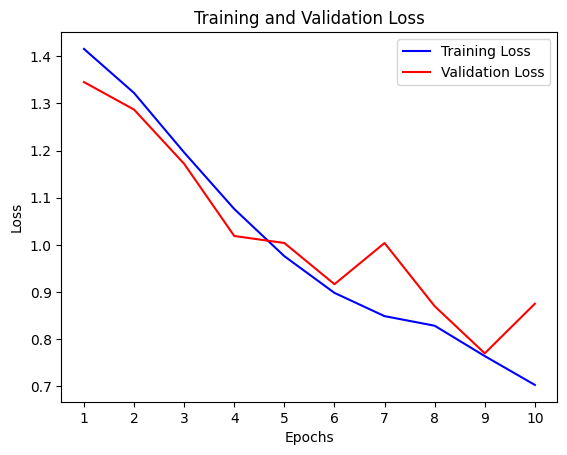

In [ ]:
history_dict = history1.history # the dictionary that has the information on loss and accuracy per epoch

loss_values = history_dict['loss']   # training loss
val_loss_values = history_dict['val_loss'] # validation loss

epochs = range(1, len(loss_values)+1)  #creates list of integers to match the number of epochs of training

# code to plot the results
plt.plot(epochs, loss_values, 'b', label="Training Loss")
plt.plot(epochs, val_loss_values, 'r', label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Loss")
plt.legend()
plt.show()

### 3.2.3 Other model

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers


model3 = Sequential()

model3.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=image_shape))
model3.add(Conv2D(32, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model3.add(Conv2D(128, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model3.add(Conv2D(512, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

# Add fully connected layers
model3.add(Flatten())
model3.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model3.add(Dropout(0.25))
model3.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model3.add(Dropout(0.25))
model3.add(Dense(4, activation='softmax', kernel_regularizer=regularizers.l2(0.001)))


# Data augmentation configuration
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [ ]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 conv2d_8 (Conv2D)           (None, 126, 126, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 conv2d_10 (Conv2D)          (None, 61, 61, 64)        36928     
                                                      

In [ ]:
model3.compile(loss ='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics =['accuracy'])

In [ ]:
# Set up training parameters
batch_size = 128
epochs = 20

# Start the timer
start_time = time.time()

# Fit the model with augmented data
history3 = model3.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                      steps_per_epoch=len(X_train) // batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(X_test, y_test))

# Calculate elapsed time
elapsed_time = time.time() - start_time

print("Training time: ", elapsed_time)

Epoch 1/20
38/38 [==============================] - 28s 585ms/step - loss: 1.5405 - accuracy: 0.2771 - val_loss: 1.4309 - val_accuracy: 0.2500
Epoch 2/20
38/38 [==============================] - 24s 642ms/step - loss: 1.3917 - accuracy: 0.2971 - val_loss: 1.3204 - val_accuracy: 0.4058
Epoch 3/20
38/38 [==============================] - 23s 606ms/step - loss: 1.2949 - accuracy: 0.3733 - val_loss: 1.2191 - val_accuracy: 0.4366
Epoch 4/20
38/38 [==============================] - 23s 590ms/step - loss: 1.1821 - accuracy: 0.4393 - val_loss: 1.2989 - val_accuracy: 0.4076
Epoch 5/20
38/38 [==============================] - 22s 579ms/step - loss: 1.1643 - accuracy: 0.4468 - val_loss: 1.0993 - val_accuracy: 0.4819
Epoch 6/20
38/38 [==============================] - 24s 615ms/step - loss: 1.1021 - accuracy: 0.4965 - val_loss: 1.0407 - val_accuracy: 0.5109
Epoch 7/20
38/38 [==============================] - 23s 603ms/step - loss: 1.0480 - accuracy: 0.5624 - val_loss: 1.1377 - val_accuracy: 0.5236

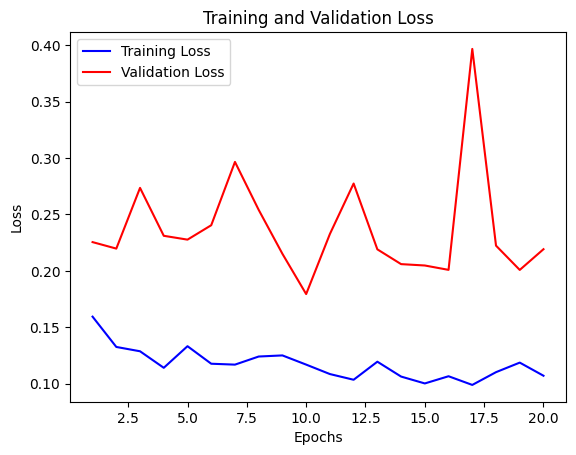

In [ ]:
history_dict = history3.history # the dictionary that has the information on loss and accuracy per epoch

loss_values = history_dict['loss']   # training loss
val_loss_values = history_dict['val_loss'] # validation loss

epochs = range(1, len(loss_values)+1)  #creates list of integers to match the number of epochs of training

# code to plot the results
plt.plot(epochs, loss_values, 'b', label="Training Loss")
plt.plot(epochs, val_loss_values, 'r', label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
#plt.xticks(epochs)
plt.ylabel("Loss")
plt.legend()
plt.show()

18/18 [==============================] - 0s 17ms/step


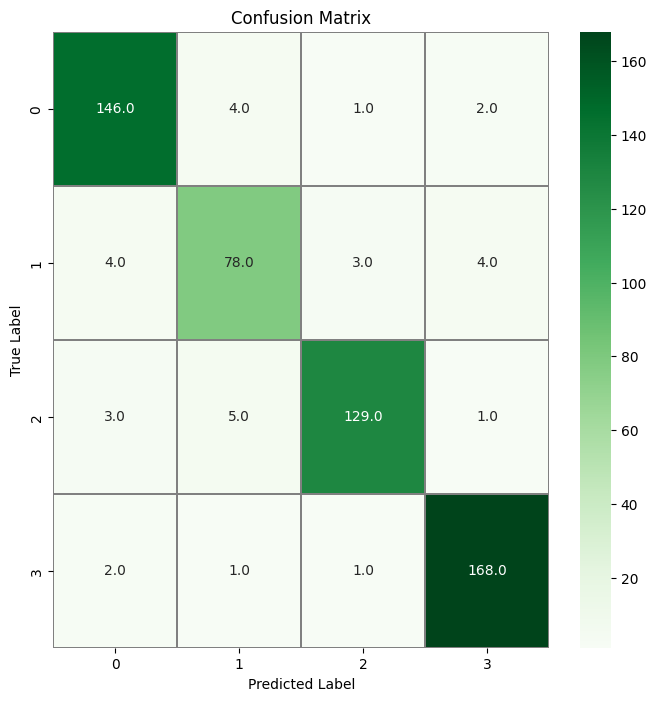

In [ ]:
# confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Predict the values from the validation dataset
y_pred = model3.predict(X_test)
# Convert predictions classes to one hot vectors
y_pred_classes = np.argmax(y_pred,axis = 1)
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

1/1 [==============================] - 0s 335ms/step


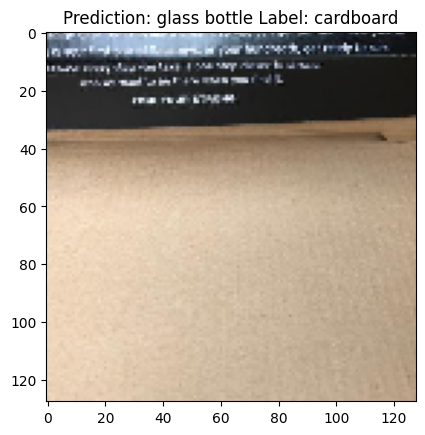

1/1 [==============================] - 0s 21ms/step


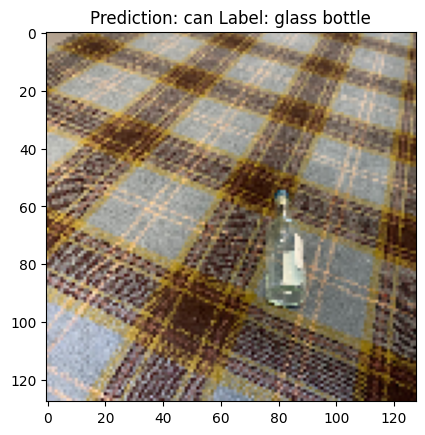

1/1 [==============================] - 0s 35ms/step


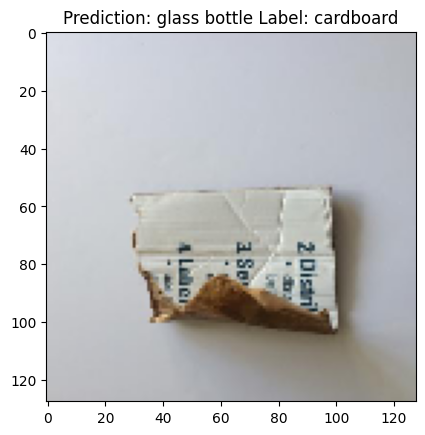

1/1 [==============================] - 0s 105ms/step


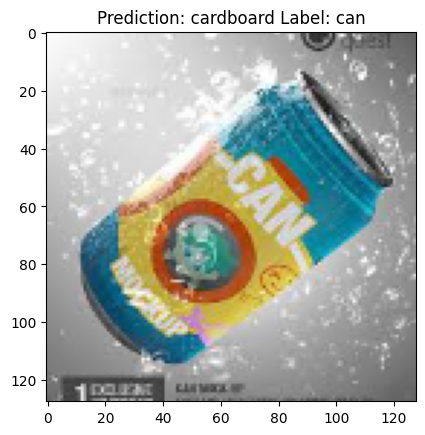

1/1 [==============================] - 0s 32ms/step


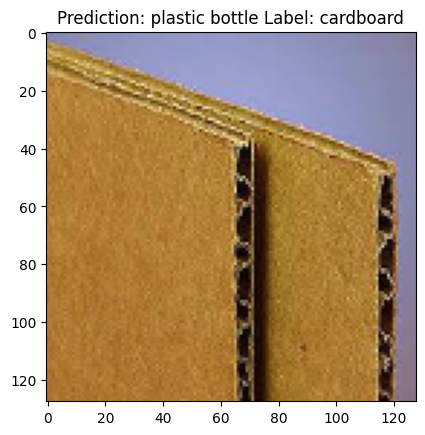

1/1 [==============================] - 0s 20ms/step


In [ ]:
class_names = ['can', 'cardboard', 'glass bottle', 'plastic bottle']

for x in range(100):
    test_image = X_test[x,:]
    predicted_cat = model3.predict(np.array([test_image])).argmax()
    label = y_test[x].argmax()
    if (predicted_cat != label):
        plt.title('Prediction: %s Label: %s' % (class_names[predicted_cat], class_names[label]))
        plt.imshow(test_image)
        plt.show()

In [ ]:
# Saving the model
model3.save(p/"model_2_94p.h5")

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('model_2_94p.h5')

# Show the model architecture
# new_model.summary()

In [ ]:
# can_test1, cardboard_test1, glass_bottle_test1, plastic_bottle_test1
img = load_img("plastic_bottle_test1.png") # load image as grayscale

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('model_2_94p.h5')


In [ ]:
# can_test1, cardboard_test1, glass_bottle_test1, plastic_bottle_test1
img = load_img("plastic_bottle_test1.png") # load image as grayscale

In [ ]:
def predictions(image):
    img_array = img_to_array(image) # convert the image to an NumPy array
    img_array_resized = smart_resize(img_array, size = (128, 128)) / 255.0 # if necessary, resize the image to 128 by 128
    reshaped_image = np.expand_dims(img_array_resized, axis=0) # reshape the image from (height, width, 3) to (1, height, width, 3) as an input to the CNN model
    probabilities = new_model.predict(reshaped_image)
    probabilities = np.round(probabilities[0,:],4 ) * 100
    return probabilities

def probability_chart(probabilities):
    x = np.array([0, 1, 2, 3])  # X-axis values
    labels = ['Can', 'Cardboard', 'Glass bottle', 'Plastic Bottle']  # Replace with your labels
    plt.bar(x, probabilities)
    plt.xticks(x, labels)  # Assigning labels to x-axis ticks
    plt.xlabel('Object')
    plt.ylabel('Probability')
    plt.title('Bar Chart')
    for i, value in enumerate(probabilities):
        chart = plt.text(i, value, str(value), ha='center', va='bottom')
    return plt.show()

In [ ]:
prob = predictions(img)

1/1 [==============================] - 0s 19ms/step


In [ ]:
prob

array([0.000e+00, 0.000e+00, 2.000e-02, 9.998e+01], dtype=float32)

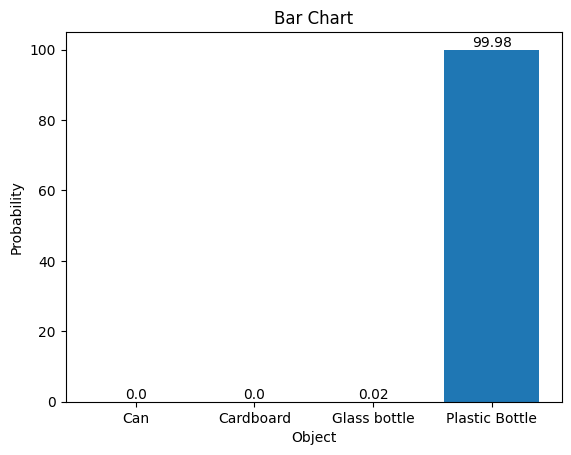

In [ ]:
probability_chart(prob)